<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [2]:
df=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
df = df.resample('1H').sum()
df.dropna()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


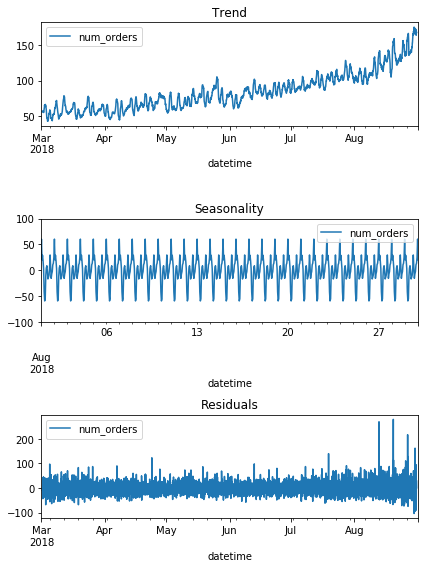

In [5]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlim('2018-08-01', '2018-08-30')
plt.ylim(-100, 100)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

## Анализ

,num_orders,rolling_mean
count,4416.000000,4317.000000
mean,84.422781,83.809532
std,45.023853,24.185334
min,0.000000,48.630000
25%,54.000000,64.360000
50%,78.000000,78.620000
75%,107.000000,99.740000
max,462.000000,160.830000


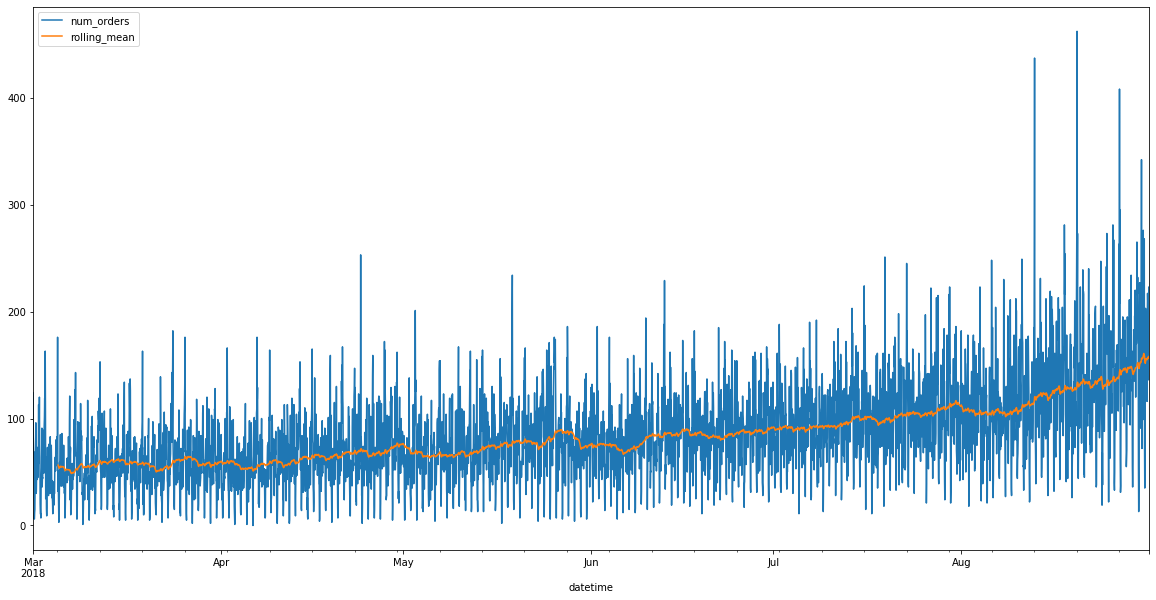

In [6]:
#df=df.query('num_orders<300')
df['rolling_mean'] = df.rolling(100).mean()
df.plot(figsize=[20, 10])
df.describe()

In [7]:
df

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,156.74
2018-08-31 20:00:00,154,156.63
2018-08-31 21:00:00,159,156.40


In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
make_features(df, 2, 24)
df

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2
datetime,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0
2018-03-01 04:00:00,43,NaN,3,4,66.0,71.0
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,4,19,207.0,217.0
2018-08-31 20:00:00,154,167.541667,4,20,136.0,207.0
2018-08-31 21:00:00,159,168.041667,4,21,154.0,136.0


Убрал прям ну совсем выбросы, но тренд восходящий, компания растет

## Обучение

In [9]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False, random_state=12345)
train_features = df_train.drop('num_orders', axis=1)
train_features=train_features.fillna(value=None, method="bfill") 
train_target = df_train['num_orders']
test_features=df_test.drop('num_orders', axis=1)
test_features=test_features.fillna(value=None, method="bfill") 
test_target = df_test['num_orders']

In [10]:
def fitrm (model):
    model.fit(train_features, train_target)
    test_predict=pd.Series(model.predict(train_features))
    mse=mean_squared_error(train_target, test_predict)
    rmse=mse**0.5
    print("Точность модели", model.score(test_features, test_target))
    print('RMSE модели:', rmse)

In [11]:
#Lr
model_lr = LinearRegression()
fitrm(model_lr)

Точность модели 0.23333725455020826
RMSE модели: 30.841222735972234


In [12]:
#Дерево решений

model = DecisionTreeRegressor(random_state=12345)
best_model = None
best_result = 0
best_leaf = 0
best_depth = 0
best_split = 2
for split in range(3, 11):
    for leaf in range(1, 11):
        for depth in range (1, 15):
            model = DecisionTreeRegressor(random_state=12345, max_depth=depth, min_samples_leaf=leaf, min_samples_split= split)
            model.fit(train_features, train_target) 
            result = model.score(test_features, test_target) 
            if result > best_result:
                best_model = model
                best_result = result
                best_leaf = leaf
                best_depth = depth
                best_split=split
print("Точность наилучшей модели:", best_result, 
      "минимум значений в листе?:", best_leaf, "Максимальная глубина:", depth, "лучшее разделение?:", best_split)

Точность наилучшей модели: 0.2420779019404088 минимум значений в листе?: 6 Максимальная глубина: 14 лучшее разделение?: 3


In [13]:
#Cat
model_cat=CatBoostRegressor(iterations=100,
                          learning_rate=0.25,
                          depth=5, random_seed=12345, verbose=0)
fitrm(model_cat)

Точность модели 0.377234965197374
RMSE модели: 18.78676703435382


In [14]:

model_gbm = lgb.LGBMRegressor(n_estimators=150, max_depth=4, boosting_type = 'gbdt', random_state=12345)
fitrm(model_gbm)

Точность модели 0.4214409090482555
RMSE модели: 18.751287733325398


In [15]:
#Случайный лес

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 101, 10):
    for depth in range (1, 15):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(train_features, train_target) 
        result = model.score(test_features, test_target) 
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("Точность наилучшей модели:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Точность наилучшей модели: 0.3654360709352242 Количество деревьев: 21 Максимальная глубина: 14


По результатам обучения моделей видно, что наименьший RMSE обучающей выборки и наивысшую точность предсказаний показали модели случайного леса и бустинги, среди них и будем выбирать лучшую модель для тестовой выборки.

## Тестирование

In [16]:
test_target

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 442, dtype: int64

In [17]:
import seaborn as sns
def fittest (model): 
    model.fit(train_features, train_target)
    preds_test=model.predict(test_features)
    mse=mean_squared_error(test_target, preds_test)
    rmse=mse**0.5
    print("RMSE модели на тестовой выборке", rmse)
    predictions = pd.Series(preds_test)
    predictions.index = test_target.index

    fig2, ax = plt.subplots(figsize=(8, 3))
    ax = sns.lineplot(data=test_target, label='Реальные')
    sns.lineplot(data=predictions, color='red', label='Предсказанные')
    plt.xticks(rotation=90)
    plt.xlim('2018-08-24', '2018-08-27')
    plt.title('Результаты модели, 2 дня')
    plt.xlabel('Дата и время')
    plt.ylabel('Число заказов');

Catboost
RMSE модели на тестовой выборке 46.20469548328721


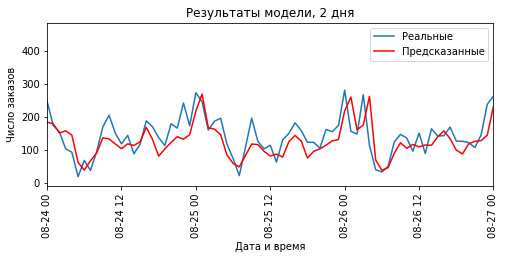

In [18]:
print('Catboost')
fittest(model_cat)

LightGBM
RMSE модели на тестовой выборке 44.53463147088845


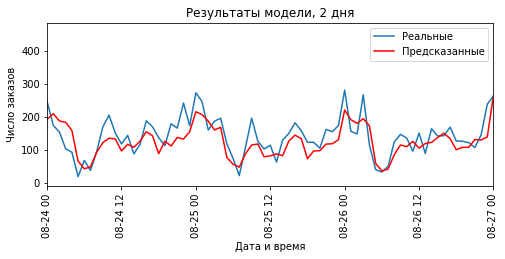

In [19]:
print('LightGBM')
fittest(model_gbm)

Random forest
RMSE модели на тестовой выборке 46.950179914266194


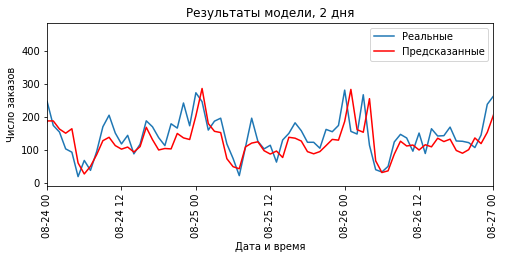

In [20]:
print('Random forest')
model_rf=model = RandomForestRegressor(random_state=12345, n_estimators=81, max_depth=14)
fittest(model_rf)

Градиентный бустинг всех победил, если через кросс-валидацию подобрать параметры, думаю может стать еще лучше, но вроде все результаты работы достигнуты, RMSE модели практически вдвое ниже требуемого, все кайф (в кэтбусте можно количество повторов до 1000 поднять и рмсе будет около 1 но точность 50% ну совсем такое)

In [21]:
dumb=np.ones(test_target.shape) * test_target.mean()
mse=mean_squared_error(test_target, dumb)
rmse=mse**0.5
print("RMSE вектора средних на тестовой выборке", rmse)

RMSE вектора средних на тестовой выборке 58.549609354757315


Ну и вектор из средних имеет довольно хреновый разброс по сравнению с моделями, но если честно точность 64% смущает, скорее всего придется добавить фичей, подобрать гиперпараметры и всякое такое